# Pitch Up Recreation Attempts
This Notebook serves to document our attempts at pitching up a track in a reconstructible manner. The first method we used was to perform an interpolation in the frequency domain, while the second was to perform resampling in the time domain.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *

In [23]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

#
# Constants to tune per run
#

# n_ffts=1024; overlap=0.5; pitch_shift_amt = 5; n_mels=128; n_mfcc=20;
# n_ffts=1024; overlap=0.75; pitch_shift_amt = 5; n_mels=128; n_mfcc=20;
# n_ffts=1024; overlap=0.75; pitch_shift_amt = 5; n_mels=256; n_mfcc=20;
n_ffts=2048; overlap=0.75; pitch_shift_amt = 5; n_mels=256; n_mfcc=20;
# n_ffts=2048; overlap=0.75; pitch_shift_amt = 1; n_mels=256; n_mfcc=20;
# n_ffts=4096 * 2; overlap=0.75; pitch_shift_amt = 1; n_mels=256; n_mfcc=20;

#
# Data Reference List
#

# data_ref_list[vowel][pitch][person]
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                                     n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

#
# Pitch Shift Pairs
#

data_label_pairs, data_label_pairs_dict = create_data_label_pairs(n_pitches)

#
# Audio files
#

all_wav_data = load_wav_files(os.path.join("Data", "dataset"), flat_data_ref_list)
print("All wav data length: {}\nTrack length: {}".format(all_wav_data.shape, all_wav_data[0].shape))

# # # # # # # # # # # # # #
# Time domain stretching  #
# # # # # # # # # # # # # #
# Option 1 - resample then stretch
all_resampled_data = resample_wavs(all_wav_data, pitch_shift_amt)
print("all_resampled_data length: {}\nTrack length: {}".format(all_resampled_data.shape, all_resampled_data[0].shape))
all_resample_then_stretched_data =  stretch_wavs(all_resampled_data, pitch_shift_amt, overlap, n_ffts=n_ffts)
print("all_resample_then_stretched_data length: {}\nTrack length: {}".format(all_resample_then_stretched_data.shape, all_resample_then_stretched_data[0].shape))
# Option 2 - stretch then resample
all_stretched_data = stretch_wavs(all_wav_data, pitch_shift_amt, overlap, n_ffts=n_ffts)
print("all_stretched_data length: {}\nTrack length: {}".format(all_stretched_data.shape, all_stretched_data[0].shape))
all_stretched_then_resampled_data = resample_wavs(all_stretched_data, pitch_shift_amt)
print("all_stretched_then_resampled_data length: {}\nTrack length: {}".format(all_stretched_then_resampled_data.shape, all_stretched_then_resampled_data[0].shape))

#
# FFT Spectrograms
#
all_spectrograms = (np.array([ stft(waveform, win_length=n_ffts, overlap=overlap, plot=False) 
                                     for waveform in all_wav_data ]))
print("All spectrograms has shape: {} (n_wavs, n_freq_bins, n_windows)".format(all_spectrograms.shape))

# # # # # # # # # # # # # #
# Time domain stretching  #
# # # # # # # # # # # # # #
all_resampled_then_stretched_spectra = (np.array([ stft(waveform, win_length=n_ffts, overlap=overlap, plot=False) 
                                                for waveform in all_resample_then_stretched_data ]))
print("all_resample_then_stretched_data has shape: {} (n_wavs, n_freq_bins, n_windows)".format(all_resampled_then_stretched_spectra.shape))
all_stretched_then_resampled_spectra = (np.array([ stft(waveform, win_length=n_ffts, overlap=overlap, plot=False) 
                                                for waveform in all_stretched_then_resampled_data ]))
print("all_stretched_then_resampled_data has shape: {} (n_wavs, n_freq_bins, n_windows)".format(all_stretched_then_resampled_spectra.shape))

# # # # # # # # # # # # # #
# Freq domain stretching  #
# # # # # # # # # # # # # #
all_pitched_spectra = np.array([ simple_ffts_pitch_shift(track_fft, pitch_shift_amt, n_ffts) 
                                 for track_fft in all_spectrograms ])
print("All pitched spectra has shape: {} (n_wavs, n_freq_bins, n_windows)".format(all_spectrograms.shape))

All wav data length: (576,)
Track length: (29400,)
all_resampled_data length: (576, 22026)
Track length: (22026,)
all_resample_then_stretched_data length: (576, 29696)
Track length: (29696,)
all_stretched_data length: (576, 39424)
Track length: (39424,)
all_stretched_then_resampled_data length: (576, 29535)
Track length: (29535,)
All spectrograms has shape: (576, 1025, 58) (n_wavs, n_freq_bins, n_windows)
all_resample_then_stretched_data has shape: (576, 1025, 59) (n_wavs, n_freq_bins, n_windows)
all_stretched_then_resampled_data has shape: (576, 1025, 58) (n_wavs, n_freq_bins, n_windows)
All pitched spectra has shape: (576, 1025, 58) (n_wavs, n_freq_bins, n_windows)


# Method 1 - Frequency Domain

## For Visual Inspection of Spectrograms

FFT Spectrogram of vowel 4, pitch 3, person 2 (3_4-cat_3-C3.wav):


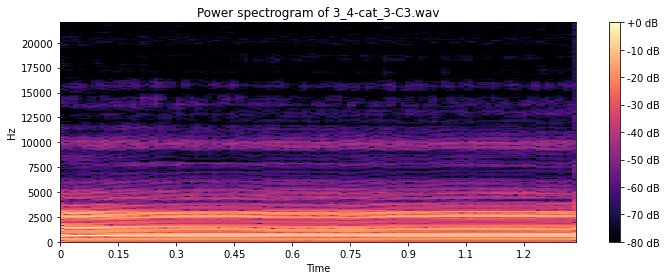

Shifted FFT Spectrogram of vowel 4, pitch 3, person 2 (3_4-cat_3-C3.wav):


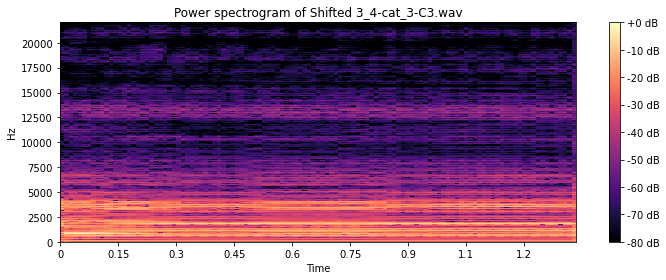

In [3]:
vIdx = 4; pIdx = 3; pid = 2;
wavIdx = flat_ref_idx(4, 3, 2)
pitched_wavIdx = flat_ref_idx(4, 3 + pitch_shift_amt, 2)

#
# Raw spectrograms
#
print("FFT Spectrogram of vowel {}, pitch {}, person {} ({}):".format(vIdx, pIdx, pid, flat_data_ref_list[wavIdx]))
plot_ffts_spectrogram(all_spectrograms[wavIdx], sample_rate,
                      flat_data_ref_list[wavIdx])

print("Shifted FFT Spectrogram of vowel {}, pitch {}, person {} ({}):".format(vIdx, pIdx, pid, flat_data_ref_list[wavIdx]))
plot_ffts_spectrogram(all_pitched_spectra[wavIdx], sample_rate,
                      "Shifted " + flat_data_ref_list[wavIdx])

## Formant Visualization
This cell simply provides some extra visualization of the FFT spectra, which allows you to see clearly the formants in the voice (resonant frequencies).

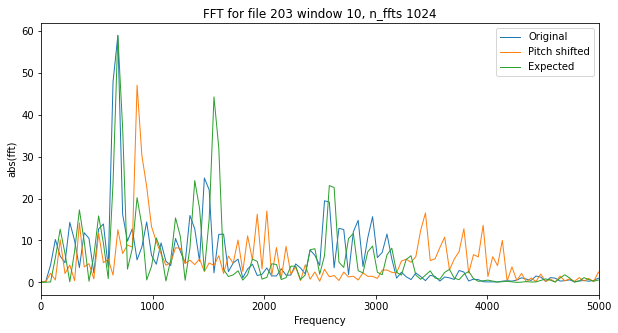

In [4]:
#
# Single FFT window look at pitch shift
#

winIdx = 10;

x_axis = librosa.core.fft_frequencies(sample_rate, n_ffts)
plt.figure(figsize=(10, 5))
plt.xlim(0, 5000)
plt.xlabel('Frequency')
plt.ylabel('abs(fft)')
plt.title("FFT for file {} window {}, n_ffts {}".format(wavIdx, winIdx, n_ffts))

plt.plot(x_axis, np.abs(all_spectrograms)[wavIdx].T[winIdx], label='Original', linewidth=1)
plt.plot(x_axis, np.abs(all_pitched_spectra)[wavIdx].T[winIdx], label='Pitch shifted', linewidth=1)
plt.plot(x_axis, np.abs(all_spectrograms)[pitched_wavIdx].T[winIdx], label='Expected', linewidth=1)

plt.legend(loc='best')

## Reconstruction of Sounds 
Finding a setting that works

[-2931 -3098 -3300 ...  8981  9251  9134]
(29184,)
[-1146 -1090 -1087 ... -1604 -1560 -1479]
(29184,)
[2479 1987 1736 ... 8088 9187 8988]
(29184,)


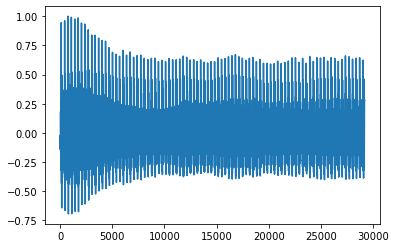

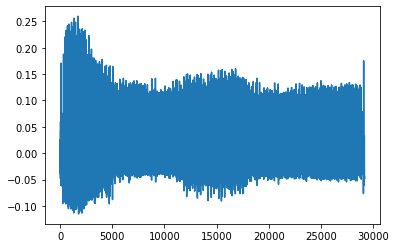

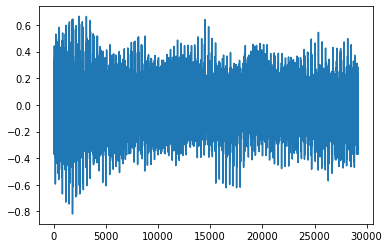

In [5]:
# The reconstructed signal - it's normalized so it's louder, but no obvious differences
istft_waveform = istft(all_spectrograms[wavIdx], overlap=overlap, win_length=n_ffts)
print(np.array(istft_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M1 ISTFT {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, istft_waveform)
plt.plot(istft_waveform)
print(istft_waveform.shape)

# The reconstructed signal - it's normalized so it's louder, but no obvious differences
istft_waveform = istft(np.abs(all_spectrograms[wavIdx]), overlap=overlap, win_length=n_ffts)
print(np.array(istft_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M1 ISTFT(ABS) {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, istft_waveform)
plt.figure()
plt.plot(istft_waveform)
print(istft_waveform.shape)

# Realed signal with griffinlim - noisy but acceptable
gl_abs_waveform = librosa.griffinlim(np.abs(all_spectrograms[wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M1 GL(ABS) {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

## Reconstruction of Pitch Shifted Sound

[ 3628  3725  4176 ... -6135 -6278 -6095]
(29184,)
[ -6424  -6310  -6056 ...  -8664 -10396 -11062]
(29184,)


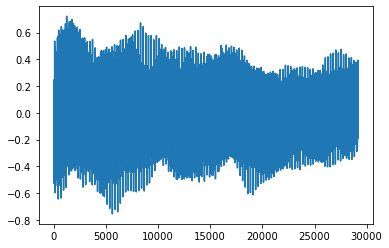

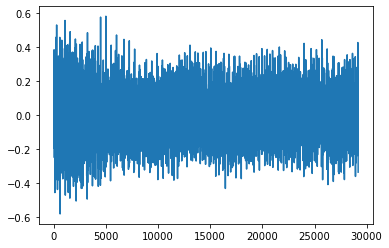

In [6]:
# Expected signal with griffinlim - noisy but acceptable

gl_abs_waveform = librosa.griffinlim(np.abs(all_spectrograms[pitched_wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M1 GL(ABS(Expected)) {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx+pitch_shift_amt], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

# Realed and pitch shifted with griffinlim - too noisy

gl_abs_waveform = librosa.griffinlim(np.abs(all_pitched_spectra[wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M1 GL(ABS(+{})) {} {} {} {}.wav'
                  .format(pitch_shift_amt, label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

# Method 2 - Resampling in Time Domain

FFT Spectrogram of vowel 4, pitch 3, person 2 (3_4-cat_3-C3.wav):


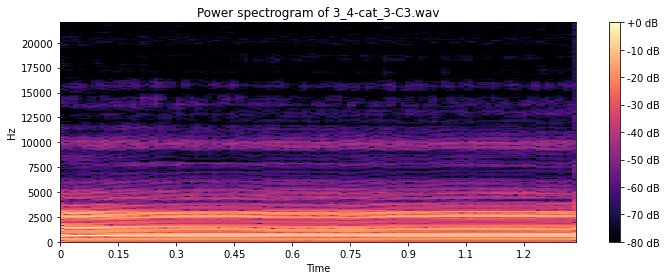

all_resampled_then_stretched_spectra Spectrogram of vowel 4, pitch 3, person 2 (3_4-cat_3-C3.wav):


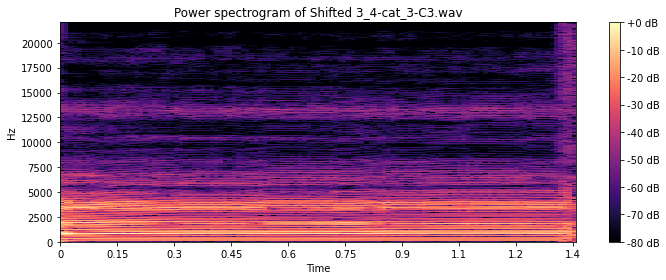

all_stretched_then_resampled_spectra Spectrogram of vowel 4, pitch 3, person 2 (3_4-cat_3-C3.wav):


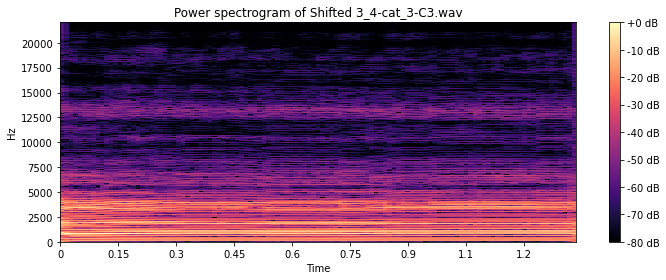

In [7]:
vIdx = 4; pIdx = 3; pid = 2;
wavIdx = flat_ref_idx(4, 3, 2)
pitched_wavIdx = flat_ref_idx(4, 3 + pitch_shift_amt, 2)

#
# Raw spectrograms
#
print("FFT Spectrogram of vowel {}, pitch {}, person {} ({}):".format(vIdx, pIdx, pid, flat_data_ref_list[wavIdx]))
plot_ffts_spectrogram(all_spectrograms[wavIdx], sample_rate,
                      flat_data_ref_list[wavIdx])

print("all_resampled_then_stretched_spectra Spectrogram of vowel {}, pitch {}, person {} ({}):".format(vIdx, pIdx, pid, flat_data_ref_list[wavIdx]))
plot_ffts_spectrogram(all_resampled_then_stretched_spectra[wavIdx], sample_rate,
                      "Shifted " + flat_data_ref_list[wavIdx])

print("all_stretched_then_resampled_spectra Spectrogram of vowel {}, pitch {}, person {} ({}):".format(vIdx, pIdx, pid, flat_data_ref_list[wavIdx]))
plot_ffts_spectrogram(all_stretched_then_resampled_spectra[wavIdx], sample_rate,
                      "Shifted " + flat_data_ref_list[wavIdx])


## Formant Visualization
This cell simply provides some extra visualization of the FFT spectra, which allows you to see clearly the formants in the voice (resonant frequencies).

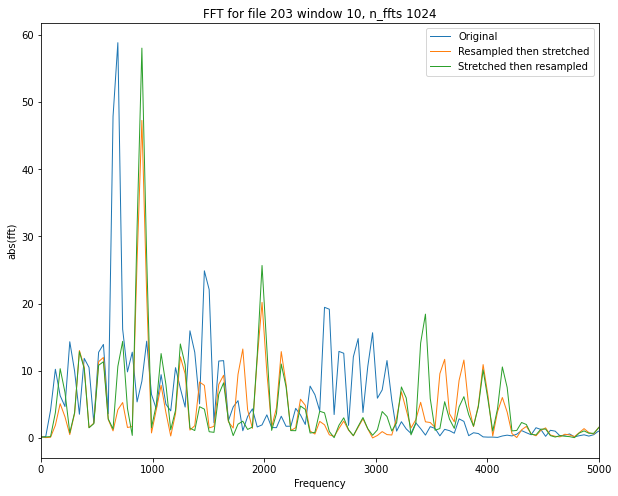

In [8]:
#
# Single FFT window look at pitch shift
#

winIdx = 10;

x_axis = librosa.core.fft_frequencies(sample_rate, n_ffts)
plt.figure(figsize=(10, 8))
plt.xlim(0, 5000)
plt.xlabel('Frequency')
plt.ylabel('abs(fft)')
plt.title("FFT for file {} window {}, n_ffts {}".format(wavIdx, winIdx, n_ffts))

plt.plot(x_axis, np.abs(all_spectrograms)[wavIdx].T[winIdx], label='Original', linewidth=1)
plt.plot(x_axis, np.abs(all_resampled_then_stretched_spectra)[wavIdx].T[winIdx], label='Resampled then stretched', linewidth=1)
plt.plot(x_axis, np.abs(all_stretched_then_resampled_spectra)[wavIdx].T[winIdx], label='Stretched then resampled', linewidth=1)
# plt.plot(x_axis, np.abs(all_spectrograms)[pitched_wavIdx].T[winIdx], label='Expected', linewidth=1)

plt.legend(loc='best')

[15613 13807 11185 ... -6939 -7464 -7589]
(29184,)
[1114 2407 3900 ... 2724 1930 2348]
(29696,)
[-8326 -7142 -5188 ...  -201   543  1512]
(29184,)


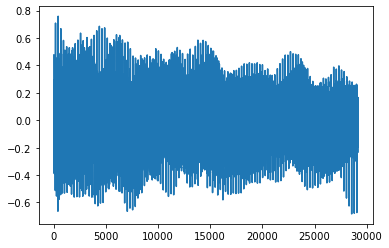

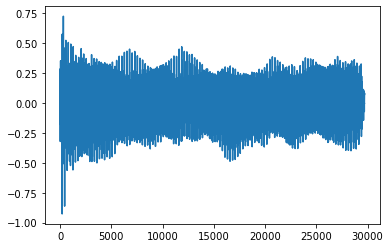

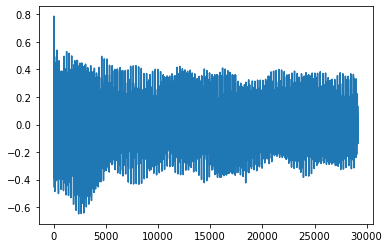

In [8]:
# Expected signal with griffinlim - noisy but acceptable
gl_abs_waveform = librosa.griffinlim(np.abs(all_spectrograms[pitched_wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M2 GL(ABS(Expected)) {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx+pitch_shift_amt], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

# Resampled
gl_abs_waveform = librosa.griffinlim(np.abs(all_resampled_then_stretched_spectra[wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M2 (resampled_then_stretched+{}) {} {} {} {}.wav'
                  .format(pitch_shift_amt, label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

# Stretched
gl_abs_waveform = librosa.griffinlim(np.abs(all_stretched_then_resampled_spectra[wavIdx]), win_length=n_ffts, hop_length=compute_hop_length(n_ffts, overlap))
print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('M2 (stretched_then_resampled+{}) {} {} {} {}.wav'
                  .format(pitch_shift_amt, label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)

## Reconstruction From Mel Spectra

In [24]:
# 
# Mel Spectrograms
#

all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, win_length=n_ffts, n_mels=n_mels, n_mfcc=n_mfcc) 
                           for ffts in all_spectrograms ])))
all_pitched_mels, all_pitched_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, win_length=n_ffts, n_mels=n_mels, n_mfcc=n_mfcc) 
                           for ffts in all_pitched_spectra ])))


print("All mels has shape: {} (n_wavs, n_mels, n_windows)".format(all_mels.shape))
print("All mfccs has shape: {} (n_wavs, n_mfcc, n_windows)".format(all_mfcc.shape))
print("All pitched mels has shape: {} (n_wavs, n_mels, n_windows)".format(all_pitched_mels.shape))
print("All pitched mfccs has shape: {} (n_wavs, n_mfcc, n_windows)".format(all_pitched_mfcc.shape))

All mels has shape: (576, 256, 58) (n_wavs, n_mels, n_windows)
All mfccs has shape: (576, 20, 58) (n_wavs, n_mfcc, n_windows)
All pitched mels has shape: (576, 256, 58) (n_wavs, n_mels, n_windows)
All pitched mfccs has shape: (576, 20, 58) (n_wavs, n_mfcc, n_windows)


[  3341   3933   4652 ... -12588 -12644 -13230]
(29184,)


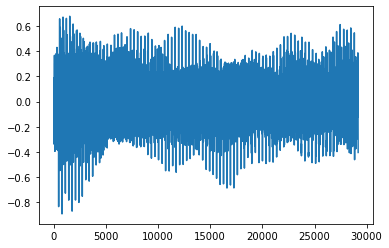

In [25]:
# Original signal with griffinlim from mel
gl_abs_waveform = librosa.feature.inverse.mel_to_audio(all_mels[wavIdx], sr=44100, n_fft=n_ffts, 
                                                       hop_length=compute_hop_length(n_ffts, overlap), 
                                                       win_length=n_ffts)

print(np.array(gl_abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('Mel GL(Mel(ABS)) {} {} {} {} {}.wav'
                  .format(label_to_vowel[vIdx], noteidx_to_pitch[pIdx], n_ffts, n_mels, overlap), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)